# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

 Transactional data is given showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

 This project is part of the Capstone project for Udacity's Data Science Nanodegree.




# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



# Approach:

Overall, the following big tasks are identified for this exercise:
1. EDA and cleaning data. This includes combining the portfolio, profile and transcript data.
2. Preprocess data for modeling
3. Run model and assess result

The following brainstorming questions may serve to inform the decisions in data processing for model input:
* Does the number of channels affect effectiveness of offer?
* Does the type of channels affect effectiveness of offer?
* What kind of customers are impacted by offers (non-frequent customers)
* How to identify frequent and non-frequent customers? (can we use std of time deltas between transactions?)
* How to identify transactions within and without offer effectiveness range?
* Can we use the ratio of transactions within and without offer effectiveness range to determine if customers is subceptible to offers?

In [21]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [22]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


From the above, it seems the *channels* column needs to be processed

In [23]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [24]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


From the above, it is clear that the *value* column needs some cleaning.  
Specifically, the column contains:
* Offer IDs in case the event is related to an offer (either received, viewed or completed)
* Sales amount in case of transactions

We start with the exploration of the profiles of the customers

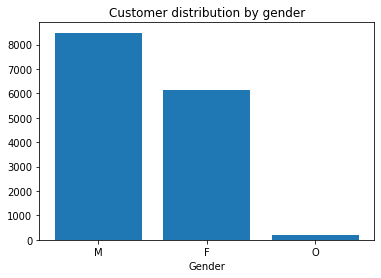

In [25]:
fig, ax1 = plt.subplots()
ax1.bar(profile.gender.value_counts().index, profile.gender.value_counts().values);
ax1.set_title("Customer distribution by gender")
ax1.set_xlabel("Gender")
plt.show()

A look at the distribution of gender shows that male customers hold the majority in the customer profile (somewhat surprising given Starbucks do not give the impression of a male-focused coffee brand)

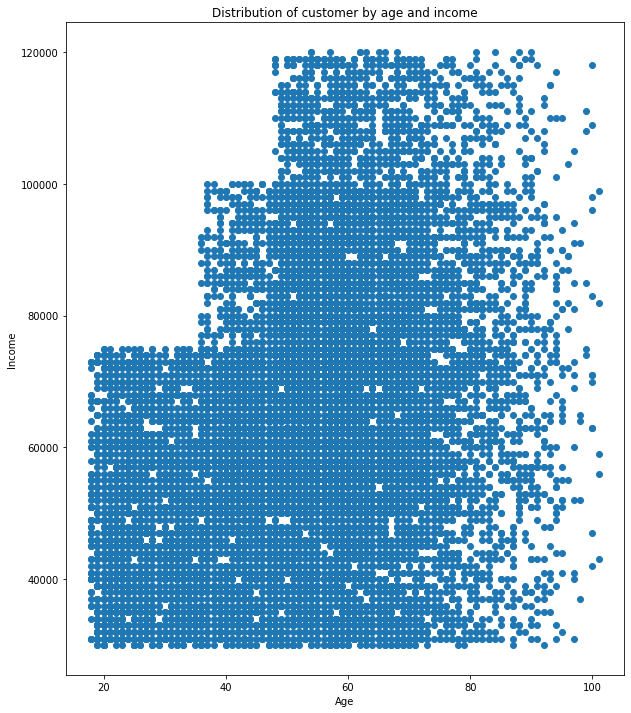

In [26]:
fig, ax2 = plt.subplots(figsize=(10,12))
ax2.scatter(profile.age.values, profile.income.values);
ax2.set_title("Distribution of customer by age and income")
ax2.set_xlabel("Age")
ax2.set_ylabel("Income")
plt.show();


An attempt at looking the correspondence between age and income, shows that it's hard to identify groupings based on these 2 features.  
However, it can be clearly seen that customers are separated clearly in to income brackets that correspond to ages, which is not surprising.  
Also not surprising is the fact that most of the customers belong to the income bracket of sub-800000.  
The shape of the data is most likely due to it being generated based on Starbucks data, and not the actual data.

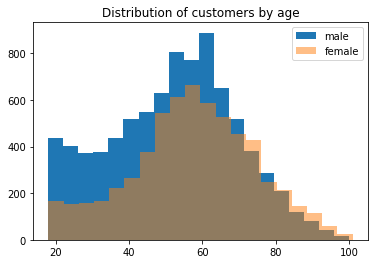

In [27]:
age_female = profile[(profile.age != 118) & (profile.gender=="F")].age.values
age_male = profile[(profile.age != 118) & (profile.gender=="M")].age.values
fig, ax1 = plt.subplots()
ax1.hist(age_male, bins=20, label="male");
ax1.hist(age_female, bins = 20, alpha=0.5, label="female")
ax1.set_title("Distribution of customers by age");
ax1.legend();

In [28]:
print("Female median age: {}".format(np.median(age_female)))
print("Male median age: {}".format(np.median(age_male)))

Female median age: 58.0
Male median age: 53.0


**Observation**:
1. Female members seems to have a higher tendency towards the middle-age group, with lower percentages comparatively in the low age group
2. Male members have much higher percentage of members in the lower age brackets (defined as below 40 years old)

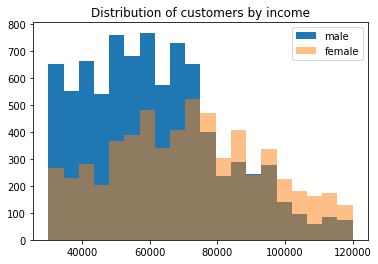

In [29]:
income_female = profile[profile.gender == "F"].income.dropna().values
income_male = profile[profile.gender == "M"].income.dropna().values
fig, ax = plt.subplots()
ax.hist(income_male, bins=20, label="male");
ax.hist(income_female, bins=20, alpha=0.5, label="female")
ax.set_title("Distribution of customers by income");
ax.legend();

In [30]:
print("Female median income: {}".format(np.median(income_female)))
print("Male median income: {}".format(np.median(income_male)))

Female median income: 71000.0
Male median income: 59000.0


**Observations:**
1. In the low to middle income groups (<=70K/year), there is a large gap between the male member counts and female member counts (which makes sense, since there are many more male members.
2. Interestingly, in the high income bracket (>70K/year), there is a slight advantage for female members. 

Text(0.5, 1.0, 'Count of different transcript events')

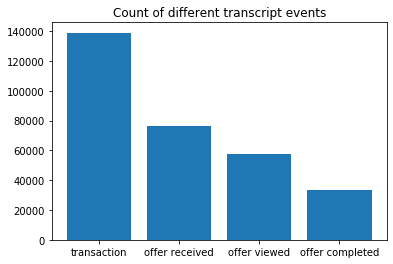

In [31]:
fig, ax = plt.subplots()
ax.bar(transcript.event.value_counts().index, transcript.event.value_counts().values);
ax.set_title("Count of different transcript events")

Just a tiny peek at the transaction data, reveal a big imbalance between the amount of transactions and the amount of offers received.
More insights can be got after the data has been processed and combined.

## Data cleaning

The steps for cleaning data is as follows:  

For **transcript.json**:
1. Change time from hours to days
2. One-hot encode where possible
3. Get the offer ids from the value columns
4. Separating time of each event in the cycle
5. Separate offer and transaction


In [32]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript["time_in_days"] = transcript["time"]/24
def encode_one_hot(df, col):
    """
    Create one-hot encoded columns 
    df: Target dataframe
    col: target column name (must be string)
    
    Return: Dataframe with encoded columns
    """
    categories = df[col].value_counts().index
    for cat in categories:
        df[cat] = df[col].apply(lambda x: 1 if x==cat else 0)
    return df

encode_one_hot(transcript, "event")

def clean_transcript_value(df):
    # The "value" column of transcript data has value in the form of dictionaries
    # Since there similar but not same keys, need to standardize the keys by popping the value of the key to be removed, and reassign it 
    # to the target key with below function 
    def clean_offer_id(dic):
        try:
            dic["offer_id"] = dic.pop("offer id")
            return dic
        except:
            return dic

    cleaned_values = df["value"].apply(clean_offer_id)

    # Get unique list of offer type keys for spliting columns
    offer_type_keys = cleaned_values.apply(lambda x: x.keys()).value_counts().index
    offer_type_keys_unique = list(set([key for keys in offer_type_keys for key in keys]))

    # Create new columns in dataframe from the value column
    for key in offer_type_keys_unique:
        df[key] = df["value"].apply(lambda x: x[key] if key in x.keys() else np.nan)
    
    return df

transcript_cleaned = clean_transcript_value(transcript)
transcript_cleaned = transcript.drop(["time","value"], axis=1)
transcript_cleaned = transcript_cleaned.reset_index()

# Separating timing of different actions
time_event = transcript_cleaned.pivot(index="index", columns="event", values="time_in_days")
time_event.columns = ["time_" + col.replace(" ","_") for col in time_event.columns]
transcript_cleaned = transcript_cleaned.merge(time_event, how="left", left_on="index", right_on="index")

# Separating offer data from transaction data
transcript_cleaned["key"] = transcript_cleaned["person"] + "|" + transcript_cleaned["offer_id"]
transcript_offer = transcript_cleaned[transcript_cleaned.transaction==0].drop(["amount"], axis=1)
transcript_transaction = transcript_cleaned[transcript_cleaned.transaction==1].drop(["reward"],axis=1)


4.
For **portfolio.json**:  
1. Get count of channels for each offer
2. One-hot encode channel column and offer type
3. Drop cleaned columns, keeping only clean outputs

In [33]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
def clean_portfolio(df):
    df["channel_count"] = df["channels"].apply(lambda x: len(x))
    channels_unique = set([channel for channels in df.channels.values for channel in channels])
    for channel in channels_unique:
        df[channel] = df["channels"].apply(lambda x: 1 if channel in x else 0)
        
    encode_one_hot(df, "offer_type")
    return df
portfolio_cleaned = clean_portfolio(portfolio)
portfolio_cleaned.drop(["channels", "offer_type"], axis=1, inplace=True)
portfolio_cleaned.set_index("id", inplace=True)
portfolio_cleaned.head()

,reward,difficulty,duration,channel_count,mobile,web,social,email,discount,bogo,informational
id,,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,3,1,0,1,1,0,1,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,4,1,1,1,1,0,1,0
3f207df678b143eea3cee63160fa8bed,0,0,4,3,1,1,0,1,0,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,3,1,1,0,1,0,1,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,2,0,1,0,1,1,0,0



For **customer profiles**, the following cleaning steps are done:
1. Scaling membership age (defined as the amount of time passed since customer becomes member, relative to the newest member)
2. Scaling member age
3. One-hot encoding gender
4. Scaling income
5. Dropping processed columns
Afterwards, uses BIRCH clustering to attempt to find customer clusters.

In [34]:
profile.gender = profile.gender.fillna("Unknown")
encode_one_hot(profile, "gender");
profile["membership_age_scaled"] = profile.became_member_on.apply(lambda x: pd.to_datetime(x, format="%Y%m%d").value / 10**9)

def scaler(df, col_name):
    return (df[col_name] - min(df[col_name])) / (max(df[col_name]) - min(df[col_name]))

#scaling membership age
profile["membership_age_scaled"] =  scaler(profile, "membership_age_scaled")

# Imputing age with mean age and scale age
# avg_age = np.round(np.mean(profile[profile.age != 118].age.values))
# profile.age.apply(lambda x: avg_age if x == 118 else x)
profile["age_scaled"] = scaler(profile, "age")

# Imputing income with mean income and scale income
profile["income_scaled"] = profile.income.fillna(np.mean(profile.income))
profile["income_scaled"] = scaler(profile, "income_scaled")
profile.set_index("id", inplace=True)
profile_cleaned = profile.drop(labels=["age","became_member_on","gender","income"], axis=1)
profile_cleaned.head()

,M,F,Unknown,O,membership_age_scaled,age_scaled,income_scaled
id,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0,0,1,0,0.709819,1.00,0.393389
0610b486422d4921ae7d2bf64640c50b,0,1,0,0,0.793747,0.37,0.911111
38fe809add3b4fcf9315a9694bb96ff5,0,0,1,0,0.992320,1.00,0.393389
78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0.756994,0.57,0.777778
a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0.804717,1.00,0.393389


## Testing of clustering

Since the problem statement calls for identifying effective coupons for certain customer groups, it is a nice occasion to try out some clustering algorithm.  
The algorithm chosen this time is **BIRCH** (which stands for "balanced iterative reducing and clustering using hierarchies").  

BIRCH is a popular unsupervised clustering algorithm for large datasets.  It clusters by continually building a tree structure of clustering features, separating the data into subclusters, before performing clustering on these subclusters. BIRCH's initial output of subclusters can also be used as input for other clustering algorithm to reduce time.  

While the current data set is not large, BIRCH has shown to give good result, and therefore a good candidate for this exercise.  

In [35]:
#Clustering using BIRCH
from sklearn.cluster import Birch
birch = Birch()
birch.fit(profile_cleaned)
cluster_labels = birch.predict(profile_cleaned)

The cluster_labels variable contains the labels of the data points in profile.  

Below is an attempt to create 3 clusters of data and visualize the result in terms of distribution of income

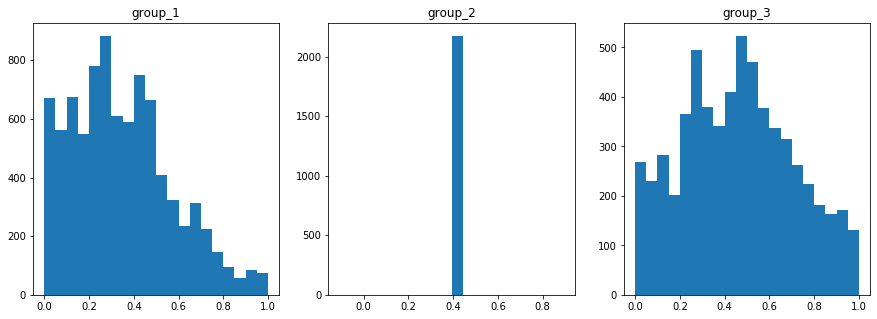

In [36]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for i in set(cluster_labels):
    filt = cluster_labels == i
    axes[i].hist(profile_cleaned[filt].income_scaled, bins=20)
    axes[i].set_title("group_{}".format(i+1))
plt.show()

It can be seen above that the BIRCH algorithm gives quite accurate result, as it correctly identifies the customer group where income is unknown as a different group (middle).  
The x-value is due to the fact that the unknown income is replaced with the mean income in the input data.

Text(0.5, 1.0, 'Colored distribution of age vs income')

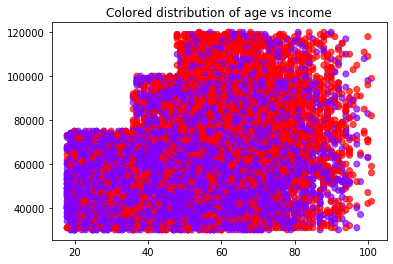

In [37]:
fig, ax = plt.subplots()
plt.scatter(profile.age, profile.income, c=cluster_labels, cmap="rainbow", alpha=0.7)
ax.set_title("Colored distribution of age vs income")

Since we have some more info related the the customer's interaction history, let's add these info to the profile and re-run the clustering algorithm

In [38]:
#Aggregate transaction history to create feature list
history_agg = transcript.groupby("person")["transaction","offer received", "offer viewed", "offer completed"].sum()
history_agg_scaled = history_agg.copy()
for col in history_agg_scaled.columns:
    history_agg_scaled[col] = scaler(history_agg_scaled, col)
profile_cleaned_with_hist = profile_cleaned.merge(history_agg_scaled, how="left", left_index=True, right_index=True)

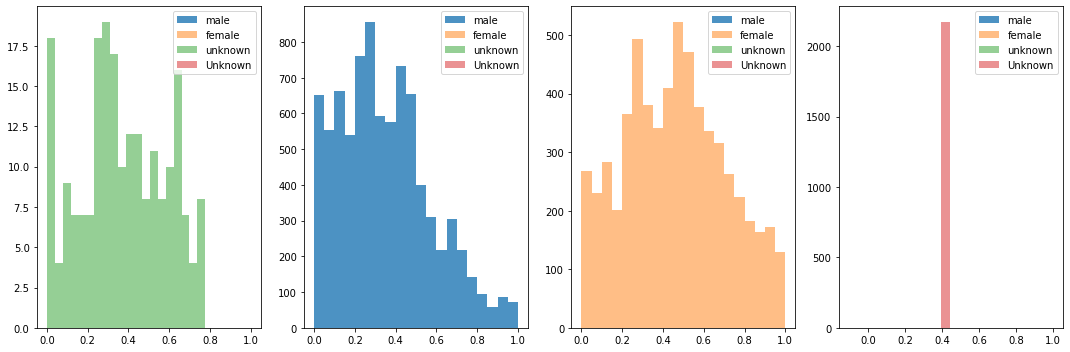

In [39]:
#Clustering using BIRCH
from sklearn.cluster import Birch
birch = Birch(n_clusters=4)
birch.fit(profile_cleaned_with_hist)
cluster_labels = birch.predict(profile_cleaned_with_hist)
fig, axes = plt.subplots(1,4, figsize=(15,5))
for i in set(cluster_labels):
    filt = cluster_labels == i
    axes[i].hist(profile_cleaned[filt & (profile_cleaned["M"]==1)].income_scaled, bins=20, alpha=0.8, label="male")
    axes[i].hist(profile_cleaned[filt & (profile_cleaned["F"]==1)].income_scaled, bins=20, alpha = 0.5, label="female")
    axes[i].hist(profile_cleaned[filt & (profile_cleaned["O"]==1)].income_scaled, bins=20, alpha = 0.5, label="unknown")
    axes[i].hist(profile_cleaned[filt & (profile_cleaned["Unknown"]==1)].income_scaled, bins=20, alpha=0.5, label="Unknown")
    axes[i].legend()
plt.tight_layout()

**Observations:** 
BIRCH clustering seems to have separated the group mostly based on gender, which is not surprising, since the other metrics do not produce any meaningful groupings.

Finally, let's manually creating the groupings based on age and income, and have a look at the activities done per group

C:\Users\vuanh\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


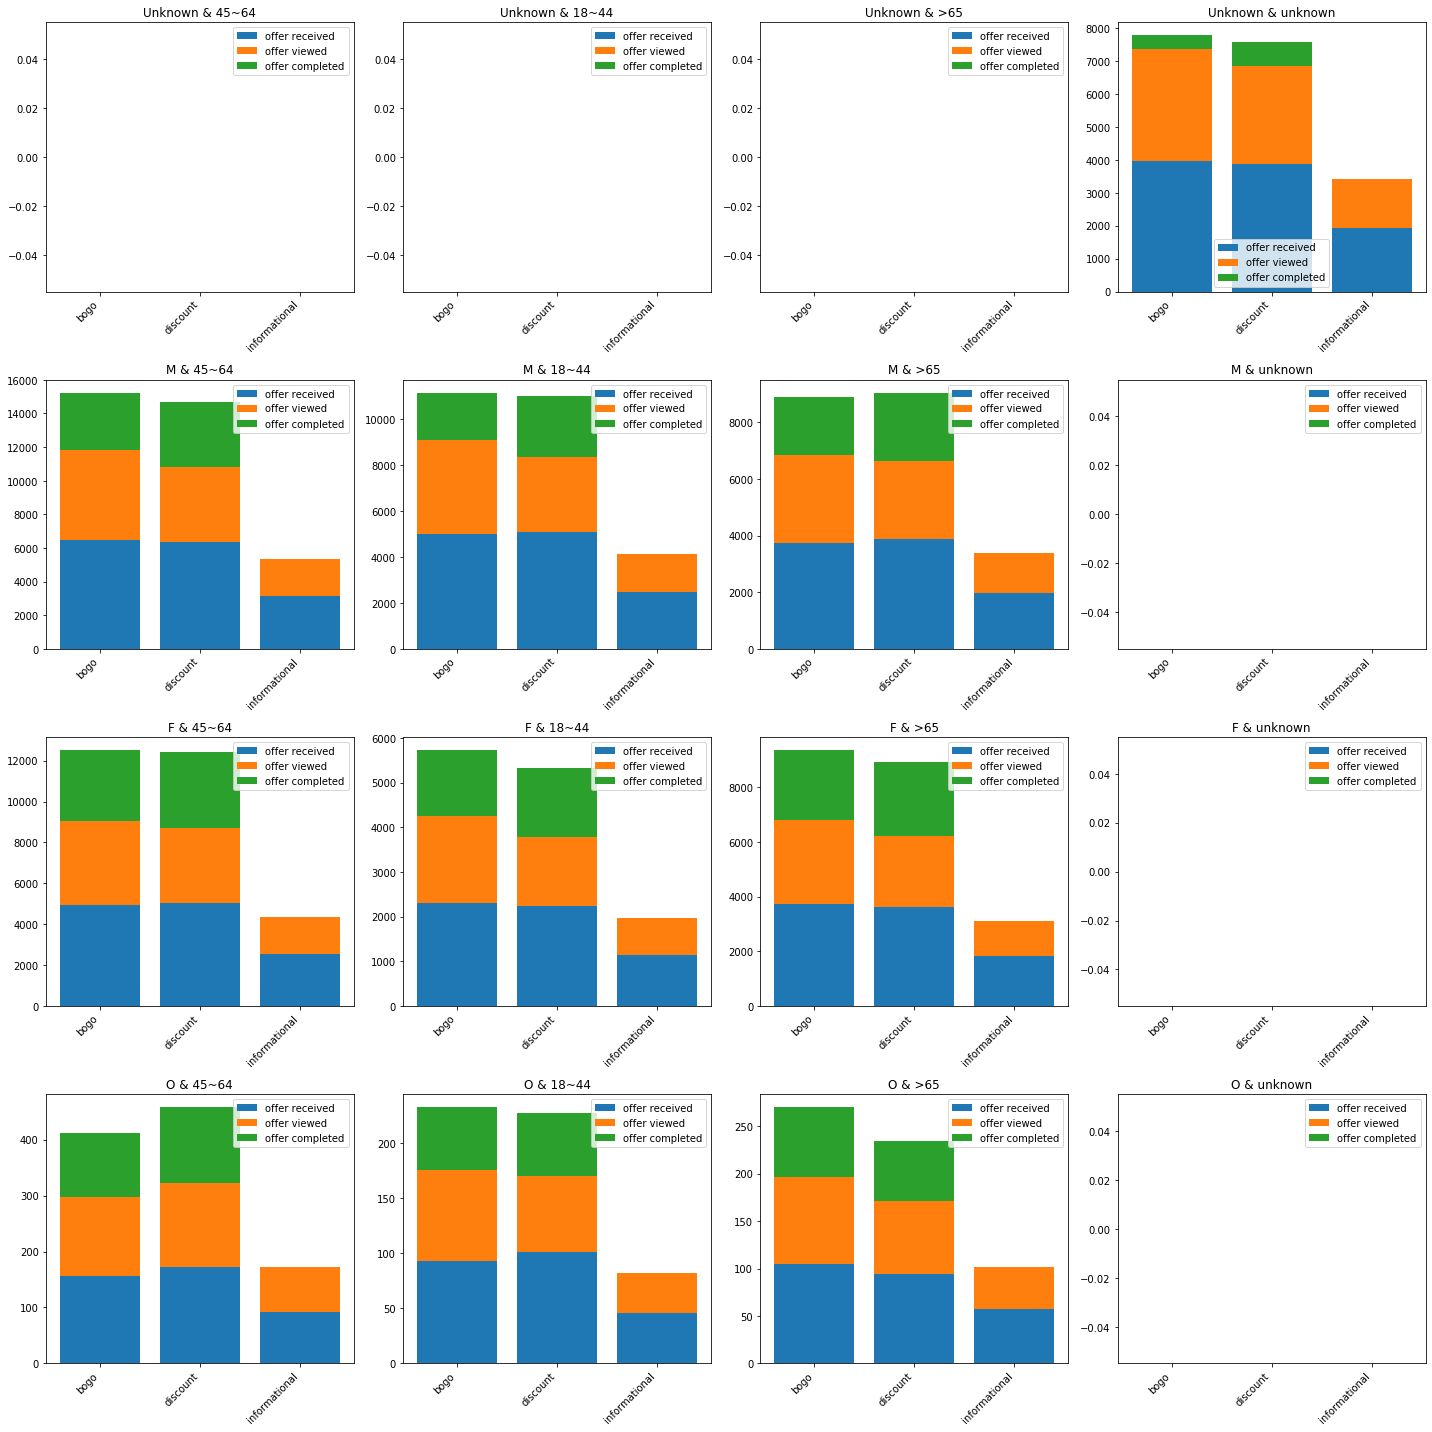

In [40]:
# Create new aggregated table of a person's offer history
person_history = transcript_offer[["person","event","offer_id"]].merge(portfolio[['email', 'mobile','social', 
                                                                'web', 'discount', 'bogo', 'informational']],
                                                     how="left",
                                                     left_on="offer_id",
                                                     right_index=True)

person_history = person_history.pivot_table(index="person", columns="event", values=["email","mobile","social","web","discount","bogo","informational"], aggfunc="sum")
person_history.columns = person_history.columns.swaplevel(1,0)
person_history.sort_index(axis=1, level=0, inplace=True)
person_history = person_history.fillna(0)

# Create new aggregated profile with transaction history
profile_agg = profile.merge(person_history, how="left", left_index=True, right_index=True)

profile_agg["income_group"] = profile_agg.income.apply(lambda x: "unknown" if pd.isnull(x)
                                                    else "<40000" if x < 40000
                                                    else "40000~80000" if x <= 80000
                                                    else ">80000")
profile_agg["age_group"] = profile_agg.age.apply(lambda x: "unknown" if x == 118
                                                else "<18" if x<18
                                                else "18~44" if x<45
                                                else "45~64" if x<65
                                                else ">65")

gender_groups = list(set(profile_agg.gender.values))
age_groups = list(set(profile_agg.age_group.values))
income_groups = list(set(profile_agg.income_group.values))
groups_dict = {"gender": gender_groups,
                "age_group": age_groups,
                "income_group": income_groups}

offer_event_types = ["offer received", "offer viewed", "offer completed"]
labels_offer_type = ['bogo', 'discount',  'informational']
labels_channel = ['email','mobile', 'social', 'web']

def draw_grid(group_1_label, group_2_label):
    group_1 = groups_dict[group_1_label]
    group_2 = groups_dict[group_2_label]
    fig, axes = plt.subplots(len(group_1), len(group_2), figsize=(20,20))
    for i in range(len(group_1)):
        for j in range(len(group_2)):
            ax = axes[i][j]
            val1 = group_1[i]
            val2 = group_2[j]
            temp = profile_agg[(profile_agg[group_1_label]==val1) & (profile_agg[group_2_label]==val2)]
            val_list = []
            for event in offer_event_types:
                val_cols = [col for col in temp.columns if event in col and col[1] in labels_offer_type and type(col) is not str]
                vals = temp[val_cols].sum().values
                val_list.append(vals)
                if len(val_list) <=1:
                    ax.bar(labels_offer_type, vals, label=event)
                else:
                    ax.bar(labels_offer_type, vals, bottom = np.sum(val_list[:-1], axis=0), label=event)
            ax.set_xticklabels(labels_offer_type, rotation=45, ha='right')
            ax.set_title(val1 + " & " + val2)
            ax.legend()
    plt.tight_layout()

draw_grid("gender", "age_group")

# Data preprocessing for model

Based on the given data, the problem can be framed as a **Regression** problem.  
An offer's "effectiveness" can be measured by how much sales it generates, versus how much it rewards the customer.  
The level of effectiveness, therefore, can be reframed as a continuous value representing the ratio between sales from transactions and rewards from offers.  
Of course, it is reasonable to assume that even discounting offers that are completed without viewed  (therefore "ineffective"), not all offers that are viewed gets completed.  
In this case, while there is no "actual reward", we can still use "potential reward" - in other words, the reward had the customer completed the offer - as a reasonable baseline against any sales generated from the offer.

### Definition of "effective" offers:
* Offers that are viewed and completed
* Offers that are viewed, and not completed, but still generate transactions

The following actions need to be done
1. Determining transactions that happens within and without an offer cycle (either between when offer is viewed and completed or was done within the validity period of offer)
2. Assign offer IDs to transactions that can be associated with an offer
3. Calculate the "effectiveness" ratio

No. 1 can be achieved by separating timing of different actions in an offer cycle.
Afterwards, if transaction timing is between a certain slot, then we can assign that transaction the corresponding offer id.  

In order to identify order cycles, some assumptions need to be made:  
1. A customer always has to receive an offer before completing it.
1. Offer activities are always done in the following order per offer cycle: offer received -> offer viewed -> offer completed

In [41]:
# Identify offer cycles
transcript_offer = transcript_offer.sort_values(by=["key","time_in_days"])
#create special id for each offer completion cycle
cycle_ids = []
initial_id = 0
for i in range(transcript_offer.shape[0]):
    if transcript_offer["offer received"].iloc[i] == 1:
        initial_id +=1
        cycle_ids.append(initial_id)
    else:
        cycle_ids.append(initial_id)
transcript_offer["cycle_id"] = cycle_ids

In [42]:
#Make a different table to calculate time elapsed betwen each stage of the offer cycle
time_elapse_table = transcript_offer.groupby(["cycle_id","key"])["offer received", "offer viewed", "offer completed", "time_offer_received", "time_offer_viewed", "time_offer_completed", "reward"].sum()
time_elapse_table["time_from_received_to_viewed"] = ((time_elapse_table["time_offer_viewed"] - time_elapse_table["time_offer_received"])
                                                     *time_elapse_table["offer viewed"]*time_elapse_table["offer received"])
time_elapse_table["time_from_viewed_to_completed"] = ((time_elapse_table["time_offer_completed"] - time_elapse_table["time_offer_viewed"]).apply(lambda x: max(x,0))
                                                     *time_elapse_table["offer completed"]*time_elapse_table["offer viewed"]).apply(lambda x: max(x,0))
time_elapse_table = time_elapse_table.reset_index()
time_elapse_table["offer_id"] = time_elapse_table["key"].apply(lambda x: x.split("|")[1])
time_elapse_table["customer_id"] = time_elapse_table["key"].apply(lambda x: x.split("|")[0])
time_elapse_table = time_elapse_table.merge(portfolio_cleaned, how="left", left_on="offer_id", right_index=True)
time_elapse_table["time_offer_expires"] = time_elapse_table["time_offer_received"] + time_elapse_table["duration"]
# time_elapse_table["reward"] = time_elapse_table["reward"].fillna(0)
time_elapse_table.rename(columns={"reward_x":"actual_reward", "reward_y":"potential_reward"}, inplace=True)
time_elapse_table.head()

,cycle_id,key,offer received,offer viewed,offer completed,time_offer_received,time_offer_viewed,time_offer_completed,actual_reward,time_from_received_to_viewed,...,duration,channel_count,mobile,web,social,email,discount,bogo,informational,time_offer_expires
0,1,0009655768c64bdeb2e877511632db8f|2906b810c7d44...,1,0,1,24.0,0.0,24.00,2.0,-0.0,...,7,3,1,1,0,1,1,0,0,31.0
1,2,0009655768c64bdeb2e877511632db8f|3f207df678b14...,1,1,0,14.0,15.5,0.00,0.0,1.5,...,4,3,1,1,0,1,0,0,1,18.0
2,3,0009655768c64bdeb2e877511632db8f|5a8bc65990b24...,1,1,0,7.0,8.0,0.00,0.0,1.0,...,3,3,1,0,1,1,0,0,1,10.0
3,4,0009655768c64bdeb2e877511632db8f|f19421c1d4aa4...,1,1,1,17.0,19.0,17.25,5.0,2.0,...,5,4,1,1,1,1,0,1,0,22.0
4,5,0009655768c64bdeb2e877511632db8f|fafdcd668e374...,1,1,1,21.0,22.5,22.00,2.0,1.5,...,10,4,1,1,1,1,1,0,0,31.0


In [43]:
#map transaction to corresponding customer/offer key if available
import os
import pickle
from tqdm import tqdm_notebook as tqdm
file_name = "key_list.pkl"
if file_name in os.listdir():
    file = open(file_name, "rb")
    corresponding_keys = pickle.load(file)
    file.close()
else:
    corresponding_keys = []
    for i in tqdm(range(transcript_transaction.shape[0])):
        time_transaction = transcript_transaction["time_transaction"].values[i]
        temp = time_elapse_table[time_elapse_table["customer_id"] == transcript_transaction["person"].values[i]]
        for j in range(temp.shape[0]):
            key = np.nan
            if (time_transaction >= temp["time_offer_viewed"].values[j]
                and temp["offer viewed"].values[j] != 0
                and (time_transaction <= temp["time_offer_completed"].values[j]
                     or time_transaction <= temp["time_offer_expires"].values[j]
                    )
               ):
                key = temp["key"].values[j]
                break
        corresponding_keys.append(key)
    filename="key_list.pkl"
    file = open(filename, "wb")
    pickle.dump(corresponding_keys, file)
    file.close()

In [44]:
# Aggregate sales count and amount based on customer-offer key
transcript_transaction["link_offer_cust_key"] = corresponding_keys
transcript_transaction["sales_count"] = 1
influenced_sales = transcript_transaction.groupby("link_offer_cust_key")[["sales_count","amount"]].sum()

The input for the model will be a combination of order event history, characteristics of customers, and characteristics of offers.  
In order to create this, aggregation of transcript data is needed.

In [45]:
#create dictionary to aggregate
def agg_dict_creator(nested_col_list, agg_types):
    """
    Create a dictionary for groupby aggregation
    
    Input:
    
    nested_col_list: list of cols to apply aggregation. Works for single agg type for multiple columns, 
    in which case please put columns with same agg type in inner list
    
    agg_types: list of aggregation methods to use. Should match valid input for groupby.agg() function. 
    Also length agg_types must equal length of col list
    """
    agg_dict = {}
    for cols, agg in zip(nested_col_list, agg_types):
        if type(cols) is list:
            for col in cols:
                agg_dict[col] = agg
        else:
            agg_dict[cols] = agg
    
    return agg_dict

cols_to_sum = ["offer received", "offer viewed", "offer completed", "actual_reward", "potential_reward"]
unneeded_cols = ["cycle_id", "key", 'time_offer_received', 'time_offer_viewed', 'time_offer_completed','time_offer_expires', "offer_id", "customer_id"]
cols_to_avg = [col for col in time_elapse_table.columns if col not in cols_to_sum and col not in unneeded_cols]

agg_dict = agg_dict_creator([cols_to_sum, cols_to_avg], ["sum", "mean"])


transaction_agg = time_elapse_table.groupby("key").agg(agg_dict)
transaction_agg = transaction_agg.merge(influenced_sales, how="left", left_index = True, right_index=True)
transaction_agg["sales_count"] = transaction_agg["sales_count"].fillna(0)
transaction_agg["amount"] = transaction_agg["amount"].fillna(0)
transaction_agg.reset_index(inplace=True)
transaction_agg["customer_id"] = transaction_agg["key"].apply(lambda x: x.split("|")[0])
transaction_agg = transaction_agg.merge(profile_cleaned, how="left", left_on="customer_id", right_index=True)
transaction_agg = transaction_agg.drop("customer_id", axis=1).set_index("key")

In [46]:
# Measure effectiveness as the ratio between sales amount vs customer rewards
effectiveness = []
for i in range(transaction_agg.shape[0]):
    sales_amt = transaction_agg["amount"].values[i]
    actual_reward = transaction_agg["actual_reward"].values[i]
    potential_reward = transaction_agg["potential_reward"].values[i]
    if actual_reward != 0:
        ratio = sales_amt/actual_reward
    elif potential_reward != 0:
        ratio = sales_amt/potential_reward
    else:
        ratio = 0
    effectiveness.append(ratio)

# Create ceiling for effectiveness:
effectiveness_ceiled = [val if val <=1 else 1 for val in effectiveness]

# Alternatively assign binary labels to effectiveness
effectiveness_binary = [1 if x >= 1 else 0 for x in effectiveness]

In [47]:
scaled_cols = []
for col in transaction_agg.columns:
    if max(transaction_agg[col])>1:
        transaction_agg[col + "_scaled"] = scaler(transaction_agg, col)
        scaled_cols.append(col + "_scaled")
    else:
        scaled_cols.append(col)
scaled_cols
model_input = transaction_agg[scaled_cols].values
model_input.shape

(63288, 26)

In [48]:
transaction_agg_reduced = transaction_agg.drop(["amount", "actual_reward", "potential_reward"],axis=1)
model_input_reduced = transaction_agg_reduced[scaled_cols].values

# Running Model

## Model

The model chosen for this exercise is Random Forest Regressor.
Random Forest is a popular ensemble model.  
While it is commonly used for classification task, it can also be used for regression task, using the above scikit-learn model.

## Metrics
The following metrics are used for evaluation of the regression model:
* RMSE (Root Mean Squared error)
* R-squared score
The above 2 metrics will give an overall picture of both the relative and absolute fit of the model to the data.

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score
import random
random.seed(42)
rfr = RandomForestRegressor()

# K-Fold evaluation using cross_validate
result = cross_validate(rfr, model_input_reduced, effectiveness_ceiled, cv=5, scoring=["neg_mean_squared_error","r2"])
result_df = pd.DataFrame(result)
result_df

C:\Users\vuanh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\vuanh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\vuanh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\vuanh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\vuanh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

,fit_time,score_time,test_neg_mean_squared_error,test_r2
0,0.766439,0.011013,-0.000049,0.999771
1,0.816390,0.012008,-0.000120,0.999439
2,0.730762,0.012296,-0.000055,0.999745
3,0.778287,0.011960,-0.000033,0.999846
4,0.757913,0.010940,-0.000082,0.999621


In [50]:
print("Max effectiveness: {}\nMin effectiveness: {}".format(max(effectiveness), min(effectiveness)))

Max effectiveness: 540.0350000000001
Min effectiveness: 0.0


As can be seen from the above, the model achieve good result in determining the "effectiveness" score of a certain customer-offer pair i.e. whether an offer is suitable or not for a customer.  
As we use multiple features of both the customer and the offer, this model should still work for new customer or new offers (reduced fit is expected)

# Hyper parameter tuning
To tune hyper parameter, uses RandomSearchCV.  
Code and explanation from this [article](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) is referenced.  

Since we are using a Random Forest Regressor model, the following features can be target for hyper-parameter tuning:

* max_depth: maximum tree depth
* max_features: maximum number of features to consider when splitting nodes
* n_estimators: number of trees
* min_samples_leaf: minimum number of data points in a leaf node

In [59]:



# Hyper parameter tuning
# To tune hyper parameter, uses RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(model_input_reduced, effectiveness_ceiled, test_size=0.2)

depths = [int(i) for i in np.linspace(10, 100, num=10)]
features = ["auto","sqrt","log2"]
trees = [int(i) for i in np.linspace(200,1000,num=10)]
leaves = [1,2,4]

search_grid = {"max_depth": depths,
                "max_features": features,
                "n_estimators": trees,
                "min_samples_leaf": leaves}

rfr = RandomForestRegressor()
rfr_random_search = RandomizedSearchCV(estimator=rfr, param_distributions=search_grid, 
                                n_iter=50, cv=3, verbose = 1, random_state=42, n_jobs = -1)

base_model = RandomForestRegressor(random_state=42)


In [60]:
def evaluate(y_true, y_pred):
    errors_squared = np.square(y_true - y_pred)
    rmse = np.sqrt(np.mean(errors_squared))
    r2 = r2_score(y_true, y_pred)
    print("RMSE :{:0.4f}".format(rmse))
    print("R-squared: {:0.2f}".format(r2))
    return

rfr_random_search.fit(X_train, y_train)
base_model.fit(X_train, y_train)

y_pred_random = rfr_random_search.predict(X_test)
y_pred_base = base_model.predict(X_test)

print("Random Model Performance:")
evaluate(y_test, y_pred_random)

print("Base Model Performance:")
evaluate(y_test, y_pred_random)

print("Random best params")
print(rfr_random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.2min finished
C:\Users\vuanh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Model Performance:
RMSE :0.0091
R-squared: 1.00
Base Model Performance:
RMSE :0.0091
R-squared: 1.00
Random best params
{'n_estimators': 377, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70}
